In [1]:
# Load libraries and set options.
import matplotlib.pyplot as plt

import glob
import os
import pandas as pd
import numpy as np
from scipy.stats import norm
%matplotlib inline
plt.rcParams['figure.figsize'] = (30, 20) 
plt.rcParams['axes.titlesize'] = 'large'

## For spectral graph partitioning.
from sklearn.cluster import spectral_clustering as spc

## Supervised learning.
from sklearn import svm, linear_model, ensemble, neighbors, tree
from sklearn import metrics, preprocessing
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline


from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.classifier import Perceptron
from mlxtend.classifier import MultiLayerPerceptron as MLP


from sklearn.feature_selection import SelectKBest, f_regression
import csv

import pandas as pd            # Processing csv files and manipulating the DataFrame.
import networkx as nx          # Graph-like object representation and manipulation module.
import matplotlib.pylab as plt # Plotting and data visualization module. 
                               # This is used for basic graph visualization.
import numpy as np       

from networkx.drawing.nx_agraph import graphviz_layout

import random

from IPython.display import Image, display

# Set global parameters for plotting. 
%matplotlib inline



In [2]:
def make_call_logs(user_id):
    all_calls = pd.read_csv('./data/FriendsFamily/CallLog.csv')
    #all_calls = all_calls.dropna(subset = ['participantID.A', 'participantID.B'])
    interactions = all_calls[['participantID.A', 'participantID.B','local_time', 'duration']]
    row_with_different_participants = interactions['participantID.A'] != interactions['participantID.B']

    # Update "interactions" to contain only the rows identified. 
    interactions = interactions.loc[row_with_different_participants,:]
    interactions.head()
    return interactions[interactions['participantID.A']==user_id]

In [3]:
def make_call_dataset():
    all_calls = pd.read_csv('./data/FriendsFamily/CallLog.csv')
    #all_calls = all_calls.dropna(subset = ['participantID.A', 'participantID.B'])
    interactions = all_calls[['participantID.A', 'participantID.B','local_time', 'duration']]
    row_with_different_participants = interactions['participantID.A'] != interactions['participantID.B']

    # Update "interactions" to contain only the rows identified. 
    interactions = interactions.loc[row_with_different_participants,:]
    
    return interactions

In [4]:
def make_SMS_dataset():
    all_calls = pd.read_csv('./data/FriendsFamily/SMSLog.csv')
    #all_calls = all_calls.dropna(subset = ['participantID.A', 'participantID.B'])
    interactions = all_calls[['participantID.A', 'participantID.B','local_time']]
    row_with_different_participants = interactions['participantID.A'] != interactions['participantID.B']

    # Update "interactions" to contain only the rows identified. 
    interactions = interactions.loc[row_with_different_participants,:]
    
    return interactions

In [5]:
def make_bluetooth_dataset():
    all_calls = pd.read_csv('./data/FriendsFamily/BluetoothProximity.csv')
    #all_calls = all_calls.dropna(subset = ['participantID.A', 'participantID.B'])
    interactions = all_calls[['participantID', 'participantID.B','date', 'address']]
    row_with_different_participants = interactions['participantID'] != interactions['participantID.B']

    # Update "interactions" to contain only the rows identified. 
    interactions = interactions.loc[row_with_different_participants,:]
    interactions = interactions.rename(columns={'participantID':'participantID.A'})
    
    return interactions

In [6]:
#load data set

In [7]:
interactions_bluetooth = make_bluetooth_dataset()

In [8]:
interactions_SMS = make_SMS_dataset()

In [9]:
interactions_call = make_call_dataset()

In [10]:
interactions = make_bluetooth_dataset()

In [11]:
#Create CallLog Centrality Measures

In [12]:
# Create an unweighted undirected graph using the NetworkX's from_pandas_edgelist method.
# The column participantID.A is used as the source and participantID.B as the target.
G = nx.from_pandas_edgelist(interactions_call, 
                             source='participantID.A', 
                             target='participantID.B', 
                             create_using=nx.Graph())

In [13]:
# Get the count of interactions between participants and display the top 5 rows.
grp_interactions = pd.DataFrame(interactions_call.groupby(['participantID.A', 'participantID.B']).size(), 
                                columns=['counts']).reset_index()
# Create a directed graph with an edge_attribute labeled counts.
g = nx.from_pandas_edgelist(grp_interactions, 
                             source='participantID.A', 
                             target='participantID.B', 
                             edge_attr='counts', 
                             create_using=nx.DiGraph())
# Set all the weights to 0 at this stage. We will add the correct weight information in the next step.
G = nx.Graph()
G.add_edges_from(g.edges(), counts=0)
for u, v, d in g.edges(data=True):
    G[u][v]['counts'] += d['counts']

In [14]:
# Plot degree centrality.
call_degree_centrality = nx.degree_centrality(G)

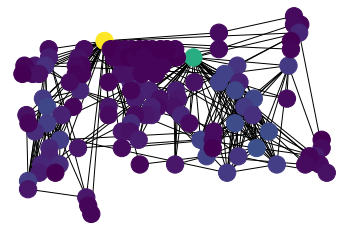

In [15]:
#skip this cell for bluetooth
colors =[call_degree_centrality[node] for node in G.nodes()]
pos = graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos, node_color=colors, node_size=300, with_labels=False)
_ = plt.axis('off') 

In [16]:
# Arrange in descending order of centrality and return the result as a tuple, i.e. (participant_id, deg_centrality).
t_call_deg_centrality_sorted = sorted(call_degree_centrality.items(), key=lambda kv: kv[1], reverse=True)

# Convert tuple to pandas dataframe.
df_call_deg_centrality_sorted = pd.DataFrame([[x,y] for (x,y) in t_call_deg_centrality_sorted], 
                                             columns=['participantID', 'deg.centrality'])

In [17]:
# Plot closeness centrality.
call_closeness_centrality = nx.closeness_centrality(G)

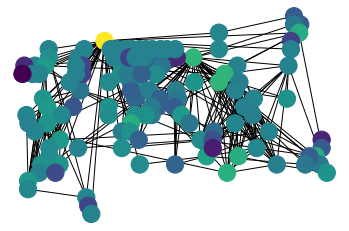

In [18]:
#skip this cell for bluetooth
colors = [call_closeness_centrality[node] for node in G.nodes()]
pos = graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos=pos,node_color=colors, with_labels=False)
_ = plt.axis('off')

In [19]:
# Arrange participants according to closeness centrality measure, in descending order. 
# Return the result as a tuple, i.e. (participant_id, cl_centrality).
t_call_clo_centrality_sorted = sorted(call_closeness_centrality.items(), key=lambda kv: kv[1], reverse=True)

# Convert tuple to pandas dataframe.
df_call_clo_centrality_sorted = pd.DataFrame([[x,y] for (x,y) in t_call_clo_centrality_sorted], 
                                             columns=['participantID', 'clo.centrality']) 

In [20]:
# Plot betweenness centrality.
call_betweenness_centrality = nx.betweenness_centrality(G)

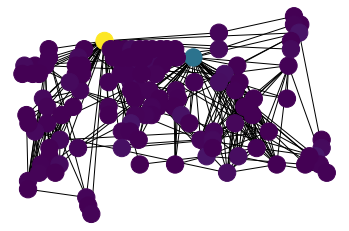

In [21]:
#skip this cell for bluetooth
colors =[call_betweenness_centrality[node] for node in G.nodes()]
pos = graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos=pos, node_color=colors, with_labels=False)
_ = plt.axis('off')

In [22]:
# Arrange participants according to betweenness centrality measure, in descending order. 
# Return the result as a tuple, i.e. (participant_id, btn_centrality). 
t_call_btn_centrality_sorted = sorted(call_betweenness_centrality.items(), key=lambda kv: kv[1], reverse=True)

# Convert tuple to a Pandas DataFrame.
df_call_btn_centrality_sorted = pd.DataFrame([[x,y] for (x,y) in t_call_btn_centrality_sorted], 
                                             columns=['participantID', 'btn.centrality']) 

In [23]:
# Plot eigenvector centrality.
call_eigenvector_centrality = nx.eigenvector_centrality(G)

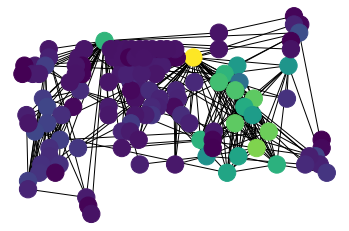

In [24]:
#skip this cell for bluetooth
colors = [call_eigenvector_centrality[node] for node in G.nodes()]
pos = graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos=pos, node_color=colors,with_labels=False)
_ = plt.axis('off')

In [25]:
# Arrange participants according to eigenvector centrality measure, in descending order. 
# Return the result as a tuple, i.e. (participant_id, eig_centrality).
t_call_eig_centrality_sorted = sorted(call_eigenvector_centrality.items(), key=lambda kv: kv[1], reverse=True)

# Convert tuple to pandas dataframe.
df_call_eig_centrality_sorted = pd.DataFrame([[x,y] for (x,y) in t_call_eig_centrality_sorted], 
                                             columns=['participantID', 'eig.centrality']) 

In [26]:
#export results to csv file
m1 = pd.merge(df_call_btn_centrality_sorted, df_call_clo_centrality_sorted)
m2 = pd.merge(m1, df_call_deg_centrality_sorted)
df_merged  = pd.merge(m2, df_call_eig_centrality_sorted)
#df_merged.to_csv('./data/FriendsFamily/Centrality_CallLog.csv', index=False)
#df_merged.to_csv('./data/FriendsFamily/Centrality_SMS.csv', index=False)
#df_merged.to_csv('./data/FriendsFamily/Centrality_Bluetooth.csv', index=False)

df_merged.to_csv('./data/FriendsFamily/Centrality_CallLog.csv', index=False)
df_merged.head()

,participantID,btn.centrality,clo.centrality,deg.centrality,eig.centrality
0,fa10-01-04,0.651025,0.624390,0.523438,0.213069
1,fa10-01-13,0.248733,0.477612,0.328125,0.326464
2,fa10-01-76,0.042644,0.465455,0.046875,0.066289
3,fa10-01-62,0.035216,0.467153,0.070312,0.055543
4,fa10-01-74,0.033967,0.444444,0.109375,0.164926


In [27]:
#Create SMS Centrality Measures

In [28]:
# Create an unweighted undirected graph using the NetworkX's from_pandas_edgelist method.
# The column participantID.A is used as the source and participantID.B as the target.
G = nx.from_pandas_edgelist(interactions_SMS, 
                             source='participantID.A', 
                             target='participantID.B', 
                             create_using=nx.Graph())

In [29]:
# Get the count of interactions between participants and display the top 5 rows.
grp_interactions = pd.DataFrame(interactions_SMS.groupby(['participantID.A', 'participantID.B']).size(), 
                                columns=['counts']).reset_index()
# Create a directed graph with an edge_attribute labeled counts.
g = nx.from_pandas_edgelist(grp_interactions, 
                             source='participantID.A', 
                             target='participantID.B', 
                             edge_attr='counts', 
                             create_using=nx.DiGraph())
# Set all the weights to 0 at this stage. We will add the correct weight information in the next step.
G = nx.Graph()
G.add_edges_from(g.edges(), counts=0)
for u, v, d in g.edges(data=True):
    G[u][v]['counts'] += d['counts']

In [30]:
# Plot degree centrality.
call_degree_centrality = nx.degree_centrality(G)

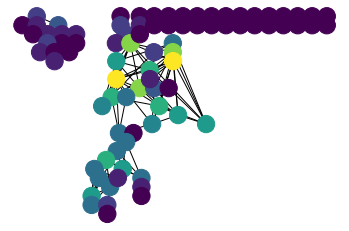

In [31]:
#skip this cell for bluetooth
colors =[call_degree_centrality[node] for node in G.nodes()]
pos = graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos, node_color=colors, node_size=300, with_labels=False)
_ = plt.axis('off') 

In [32]:
# Arrange in descending order of centrality and return the result as a tuple, i.e. (participant_id, deg_centrality).
t_call_deg_centrality_sorted = sorted(call_degree_centrality.items(), key=lambda kv: kv[1], reverse=True)

# Convert tuple to pandas dataframe.
df_call_deg_centrality_sorted = pd.DataFrame([[x,y] for (x,y) in t_call_deg_centrality_sorted], 
                                             columns=['participantID', 'deg.centrality'])

In [33]:
# Plot closeness centrality.
call_closeness_centrality = nx.closeness_centrality(G)

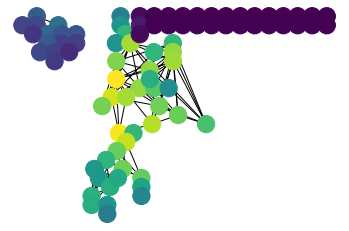

In [34]:
#skip this cell for bluetooth
colors = [call_closeness_centrality[node] for node in G.nodes()]
pos = graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos=pos,node_color=colors, with_labels=False)
_ = plt.axis('off')

In [35]:
# Arrange participants according to closeness centrality measure, in descending order. 
# Return the result as a tuple, i.e. (participant_id, cl_centrality).
t_call_clo_centrality_sorted = sorted(call_closeness_centrality.items(), key=lambda kv: kv[1], reverse=True)

# Convert tuple to pandas dataframe.
df_call_clo_centrality_sorted = pd.DataFrame([[x,y] for (x,y) in t_call_clo_centrality_sorted], 
                                             columns=['participantID', 'clo.centrality']) 

In [36]:
# Plot betweenness centrality.
call_betweenness_centrality = nx.betweenness_centrality(G)

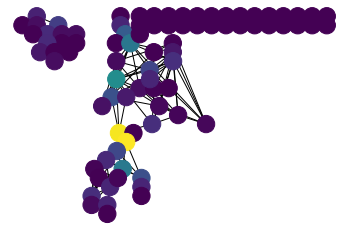

In [37]:
#skip this cell for bluetooth
colors =[call_betweenness_centrality[node] for node in G.nodes()]
pos = graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos=pos, node_color=colors, with_labels=False)
_ = plt.axis('off')

In [38]:
# Arrange participants according to betweenness centrality measure, in descending order. 
# Return the result as a tuple, i.e. (participant_id, btn_centrality). 
t_call_btn_centrality_sorted = sorted(call_betweenness_centrality.items(), key=lambda kv: kv[1], reverse=True)

# Convert tuple to a Pandas DataFrame.
df_call_btn_centrality_sorted = pd.DataFrame([[x,y] for (x,y) in t_call_btn_centrality_sorted], 
                                             columns=['participantID', 'btn.centrality']) 

In [39]:
# Plot eigenvector centrality.
call_eigenvector_centrality = nx.eigenvector_centrality(G)

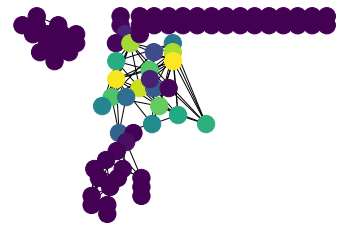

In [40]:
#skip this cell for bluetooth
colors = [call_eigenvector_centrality[node] for node in G.nodes()]
pos = graphviz_layout(G, prog='dot')
nx.draw_networkx(G, pos=pos, node_color=colors,with_labels=False)
_ = plt.axis('off')

In [41]:
# Arrange participants according to eigenvector centrality measure, in descending order. 
# Return the result as a tuple, i.e. (participant_id, eig_centrality).
t_call_eig_centrality_sorted = sorted(call_eigenvector_centrality.items(), key=lambda kv: kv[1], reverse=True)

# Convert tuple to pandas dataframe.
df_call_eig_centrality_sorted = pd.DataFrame([[x,y] for (x,y) in t_call_eig_centrality_sorted], 
                                             columns=['participantID', 'eig.centrality']) 

In [42]:
#export results to csv file
m1 = pd.merge(df_call_btn_centrality_sorted, df_call_clo_centrality_sorted)
m2 = pd.merge(m1, df_call_deg_centrality_sorted)
df_merged  = pd.merge(m2, df_call_eig_centrality_sorted)
#df_merged.to_csv('./data/FriendsFamily/Centrality_CallLog.csv', index=False)
#df_merged.to_csv('./data/FriendsFamily/Centrality_SMS.csv', index=False)
#df_merged.to_csv('./data/FriendsFamily/Centrality_Bluetooth.csv', index=False)

df_merged.to_csv('./data/FriendsFamily/Centrality_SMS.csv', index=False)
df_merged.head()

,participantID,btn.centrality,clo.centrality,deg.centrality,eig.centrality
0,fa10-01-38,0.109903,0.163619,0.060241,0.014767
1,sp10-01-46,0.108421,0.176205,0.060241,0.111009
2,sp10-01-39,0.053644,0.177916,0.144578,0.346816
3,fa10-01-82,0.044397,0.142057,0.084337,0.002874
4,sp10-01-49,0.043746,0.155299,0.120482,0.302168


In [43]:
# Create an unweighted undirected graph using the NetworkX's from_pandas_edgelist method.
# The column participantID.A is used as the source and participantID.B as the target.
G = nx.from_pandas_edgelist(interactions_bluetooth, 
                             source='participantID.A', 
                             target='participantID.B', 
                             create_using=nx.Graph())

In [44]:
# Get the count of interactions between participants and display the top 5 rows.
grp_interactions = pd.DataFrame(interactions_bluetooth.groupby(['participantID.A', 'participantID.B']).size(), 
                                columns=['counts']).reset_index()
# Create a directed graph with an edge_attribute labeled counts.
g = nx.from_pandas_edgelist(grp_interactions, 
                             source='participantID.A', 
                             target='participantID.B', 
                             edge_attr='counts', 
                             create_using=nx.DiGraph())
# Set all the weights to 0 at this stage. We will add the correct weight information in the next step.
G = nx.Graph()
G.add_edges_from(g.edges(), counts=0)
for u, v, d in g.edges(data=True):
    G[u][v]['counts'] += d['counts']

In [45]:
# Plot degree centrality.
call_degree_centrality = nx.degree_centrality(G)

In [46]:
#skip degree centrality diagram for bluetooth


In [47]:
# Arrange in descending order of centrality and return the result as a tuple, i.e. (participant_id, deg_centrality).
t_call_deg_centrality_sorted = sorted(call_degree_centrality.items(), key=lambda kv: kv[1], reverse=True)

# Convert tuple to pandas dataframe.
df_call_deg_centrality_sorted = pd.DataFrame([[x,y] for (x,y) in t_call_deg_centrality_sorted], 
                                             columns=['participantID', 'deg.centrality'])

In [48]:
# Plot closeness centrality.
call_closeness_centrality = nx.closeness_centrality(G)

In [49]:
#skip closeness centrality diagram for bluetooth


In [50]:
# Arrange participants according to closeness centrality measure, in descending order. 
# Return the result as a tuple, i.e. (participant_id, cl_centrality).
t_call_clo_centrality_sorted = sorted(call_closeness_centrality.items(), key=lambda kv: kv[1], reverse=True)

# Convert tuple to pandas dataframe.
df_call_clo_centrality_sorted = pd.DataFrame([[x,y] for (x,y) in t_call_clo_centrality_sorted], 
                                             columns=['participantID', 'clo.centrality']) 

In [51]:
# Plot betweenness centrality.
call_betweenness_centrality = nx.betweenness_centrality(G)

In [52]:
#skip betweenness centrality diagram for bluetooth

In [53]:
# Arrange participants according to betweenness centrality measure, in descending order. 
# Return the result as a tuple, i.e. (participant_id, btn_centrality). 
t_call_btn_centrality_sorted = sorted(call_betweenness_centrality.items(), key=lambda kv: kv[1], reverse=True)

# Convert tuple to a Pandas DataFrame.
df_call_btn_centrality_sorted = pd.DataFrame([[x,y] for (x,y) in t_call_btn_centrality_sorted], 
                                             columns=['participantID', 'btn.centrality']) 

In [54]:
# Plot eigenvector centrality.
call_eigenvector_centrality = nx.eigenvector_centrality(G)

In [55]:
#skip eigenvector centrality diagram for bluetooth

In [56]:
# Arrange participants according to eigenvector centrality measure, in descending order. 
# Return the result as a tuple, i.e. (participant_id, eig_centrality).
t_call_eig_centrality_sorted = sorted(call_eigenvector_centrality.items(), key=lambda kv: kv[1], reverse=True)

# Convert tuple to pandas dataframe.
df_call_eig_centrality_sorted = pd.DataFrame([[x,y] for (x,y) in t_call_eig_centrality_sorted], 
                                             columns=['participantID', 'eig.centrality']) 

In [57]:
#export results to csv file
m1 = pd.merge(df_call_btn_centrality_sorted, df_call_clo_centrality_sorted)
m2 = pd.merge(m1, df_call_deg_centrality_sorted)
df_merged  = pd.merge(m2, df_call_eig_centrality_sorted)
#df_merged.to_csv('./data/FriendsFamily/Centrality_CallLog.csv', index=False)
#df_merged.to_csv('./data/FriendsFamily/Centrality_SMS.csv', index=False)
#df_merged.to_csv('./data/FriendsFamily/Centrality_Bluetooth.csv', index=False)

df_merged.to_csv('./data/FriendsFamily/Centrality_Bluetooth.csv', index=False)
df_merged.head()

,participantID,btn.centrality,clo.centrality,deg.centrality,eig.centrality
0,sp10-01-53,0.015885,0.905405,0.895522,0.099965
1,sp10-01-48,0.010227,0.957143,0.955224,0.102394
2,fa10-01-03,0.008730,0.848101,0.820896,0.094565
3,sp10-01-32,0.008674,0.924138,0.917910,0.100822
4,fa10-01-04,0.008216,0.822086,0.783582,0.090599


In [58]:
influencer_call = pd.read_csv('./data/FriendsFamily/Centrality_CallLog_trimmed.csv')
influencer_sms = pd.read_csv('./data/FriendsFamily/Centrality_SMSLog_trimmed.csv')
influencer_bluetooth = pd.read_csv('./data/FriendsFamily/Centrality_Bluetooth_trimmed.csv')

In [59]:
influencers = pd.merge(influencer_call['participantID'], influencer_sms['participantID'], on = 'participantID')

In [60]:
influencers = pd.merge(influencers,influencer_bluetooth['participantID'], on = 'participantID')

In [61]:
influencers.to_csv('./data/FriendsFamily/Centrality_Influencers.csv', index=False)